In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLine2D
import osmnx as ox
from collections import Counter
from tabulate import tabulate
import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Get local shapefiles from GeoPackage
data_pkg_path = '../Shapefiles'
filename = 'Cambridge_trees_zones.gpkg'
path = os.path.join(data_pkg_path, filename)

In [3]:
# Read shapefiles
zones_gdf = gpd.read_file(path, layer='CDD_ZoningDistricts')
trees_gdf = gpd.read_file(path, layer='ENVIRONMENTAL_StreetTrees')

#filter retired trees, stumps, and planting areas, as well as non street trees
current_trees = trees_gdf[trees_gdf['SiteType'] == 'Tree']
street_trees = current_trees[current_trees['Location'] == 'Street Tree']
print(len(street_trees))

14797


In [4]:
# Define zone groups
residential = ['A-1', 'A-2', 'B', 'C', 'C-1', 'C-1A', 'C-2', 'C-2A', 'C-2B', 'C-3', 'C-3A', 'C-3B']
office = ['O-1', 'O-3', 'O-2', 'O-2A', 'O-3A']
business = ['BA-1', 'BA-2', 'BA-4', 'BB', 'BA', 'BA-3', 'BB-2', 'BB-1', 'BC', 'BA-5']
industry = ['IA', 'IA-1', 'IB-1', 'IA-2', 'IB', 'IB-2']
open_spaces = ['OS']

In [5]:
# Function to add group label to each zone polygon
def label_dist(row):
    if row['ZONE_TYPE'] in residential:
        return 'Residential'
    if row['ZONE_TYPE'] in office:
        return 'Office'
    if row['ZONE_TYPE'] in business:
        return 'Business'
    if row['ZONE_TYPE'] in industry:
        return 'Industry'
    if row['ZONE_TYPE'] in open_spaces:
        return 'Open_Spaces'
    return 'Special'

In [6]:
# Use function to apply group field
zones_gdf['group'] = zones_gdf.apply(label_dist, axis=1)

In [7]:
# Perform spatial join between zones and trees
joined = gpd.sjoin(street_trees, zones_gdf, how='left', predicate='within')
len(joined) # check that the length is the same

14797

In [8]:
# Get OSM data for Cambridge, MA
location = 'Cambridge, MA'
graph = ox.graph.graph_from_place(location, simplify=True, network_type= 'drive')

In [9]:
# Reproject graph, zones, and trees data
graph_reprojected = ox.project_graph(graph)
zones_gdf = zones_gdf.to_crs(graph_reprojected.graph['crs'])
street_trees = street_trees.to_crs(graph_reprojected.graph['crs'])

In [10]:
# Function to calculate street length in each zone
def get_street_length(row):
    mPoly = row['geometry'].geoms[0]
    try:
        tGraph = ox.truncate.truncate_graph_polygon(graph_reprojected, mPoly)
    except:
        return 0
    tGraph = ox.convert.to_undirected(tGraph)
    sLength = ox.stats.street_length_total(tGraph)
    return sLength

In [11]:
# Use function to add street length field
zones_gdf['street_len'] = zones_gdf.apply(get_street_length, axis=1)
zones_gdf.head()

,ZONE_TYPE,ZCODE,GlobalID,PUD_TYPE_N,PUD_TYPE,SHAPE_area,SHAPE_len,geometry,group,street_len
0,C-2,47,{EB3A515E-6AE9-49D4-AFA1-FC599E764734},None,None,1.213249e+05,3048.305574,"MULTIPOLYGON (((325422.289 4694696.861, 325419...",Residential,0.000
1,B,49,{08280727-1831-467F-A3BE-7C31410146F3},None,None,1.983588e+06,9401.258356,"MULTIPOLYGON (((325487.219 4694671.989, 325473...",Residential,2327.602
2,BA-1,51,{C328FC03-C845-4221-A287-1C77E2E0F8B9},None,None,3.141068e+05,3152.229849,"MULTIPOLYGON (((324598.769 4694464.027, 324627...",Business,360.885
3,B,52,{65359CF3-DB83-4331-B9AA-722B13E01B81},None,None,6.398621e+04,1588.508902,"MULTIPOLYGON (((325026.552 4694598.203, 325019...",Residential,0.000
4,C-1,54,{42F5AC2C-0269-44B4-A58A-6E2E65A2EEDF},None,None,3.889696e+05,3851.094267,"MULTIPOLYGON (((325076.564 4694476.371, 325068...",Residential,452.229


In [12]:
# Get the total street length for each zone group
results = pd.DataFrame(zones_gdf.groupby('group')['street_len'].sum())

In [13]:
# Add tree counts to results dataframe
results['tree_count'] = joined.groupby('group').size()

In [14]:
# Calculate trees per meter of road
results['trees_m'] = results['tree_count'] / results['street_len']
print(results)

             street_len  tree_count   trees_m
group                                        
Business      15313.429        1763  0.115128
Industry       3437.822         576  0.167548
Office         3142.187         380  0.120935
Open_Spaces   24155.793         515  0.021320
Residential   86207.595       10319  0.119699
Special        7874.773        1193  0.151496


In [15]:
# Check for ties in most common tree species
commonTest = joined.groupby('group')['CommonName'].apply(lambda x: Counter(x).most_common(2))
print(commonTest)

group
Business           [(Honeylocust, 313), (Red maple, 131)]
Industry        [(London planetree, 94), (Red maple, 65)]
Office                 [(Honeylocust, 44), (Pin oak, 34)]
Open_Spaces              [(Pin oak, 103), (sycamore, 76)]
Residential    [(Honeylocust, 1114), (Norway maple, 829)]
Special            [(Red maple, 133), (Honeylocust, 126)]
Name: CommonName, dtype: object


In [16]:
# Add most common species for each group
results['common'] = joined.groupby('group')['CommonName'].apply(lambda x: Counter(x).most_common(1)[0][0])
results = results.sort_values(by='trees_m', ascending=False)
print(results)

             street_len  tree_count   trees_m            common
group                                                          
Industry       3437.822         576  0.167548  London planetree
Special        7874.773        1193  0.151496         Red maple
Office         3142.187         380  0.120935       Honeylocust
Residential   86207.595       10319  0.119699       Honeylocust
Business      15313.429        1763  0.115128       Honeylocust
Open_Spaces   24155.793         515  0.021320           Pin oak


In [17]:
# Format table values for display
pd.set_option('mode.chained_assignment', None)
cols = ['street_len', 'tree_count', 'common']
display_table = results[cols]
display_table['Zone\nGroup'] = display_table.index
display_table.insert(0, 'Zone\nGroup', display_table.pop('Zone\nGroup'))
display_table['street_len'] = display_table['street_len'].round(2)
display_table = display_table.rename(columns={'street_len': 'Street\nLength(m)', 
                                              'tree_count': 'Street\nTrees', 
                                              'common': 'Most\nCommon'})
display_table['Zone\nGroup'][5] = 'Open Spaces'
print(display_table)

             Zone\nGroup  Street\nLength(m)  Street\nTrees      Most\nCommon
group                                                                       
Industry        Industry            3437.82            576  London planetree
Special          Special            7874.77           1193         Red maple
Office            Office            3142.19            380       Honeylocust
Residential  Residential           86207.60          10319       Honeylocust
Business        Business           15313.43           1763       Honeylocust
Open_Spaces  Open Spaces           24155.79            515           Pin oak


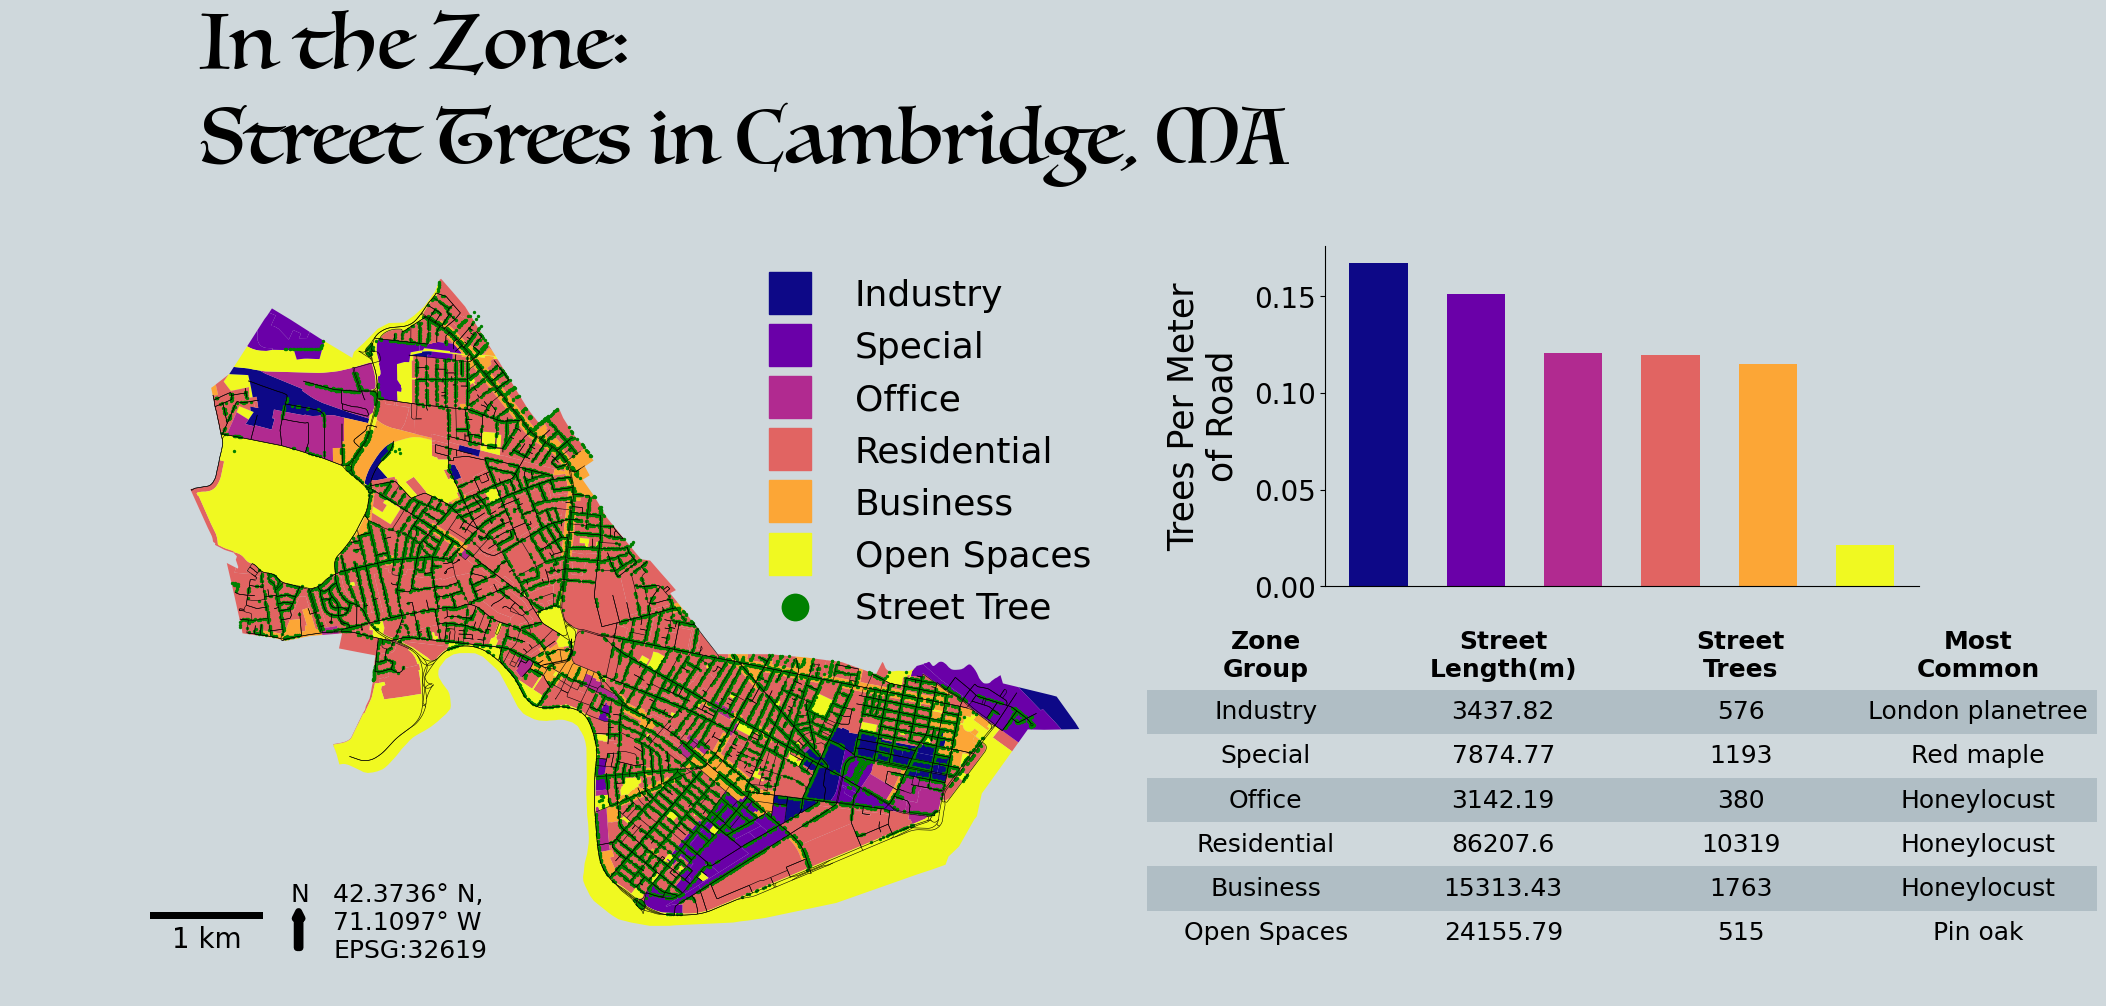

In [33]:
# Create figure
fig = plt.figure(figsize=(24, 10))
gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1])
plt.subplots_adjust(wspace=-0.5, hspace = 0.4)
fig.set_facecolor('#cfd8dc')
fig.suptitle('In the Zone:\nStreet Trees in Cambridge, MA', 
             fontsize=55, fontfamily='Luminari', horizontalalignment='left', x=0.2, y=1.03)

# Create subplots
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

axes = [ax1, ax2, ax3]
for ax in axes:
    ax.set_facecolor('none')

### Map ###

# Create custom legend ordered by street trees per meter of road length
my_cmap = plt.get_cmap("plasma")
colors = my_cmap(np.linspace(0, 1, 6)).tolist()
vals = results['trees_m'].tolist()
colors_ordered = [x for _,x in sorted(zip(vals, colors))]
colors_ordered.reverse()
groups = display_table['Zone\nGroup'].tolist()

legend_elements = [Line2D([0], [0], 
                   marker = 's', 
                   markersize=30,
                   linestyle='None',
                   color=color) for color in colors_ordered]

ax1.legend(legend_elements, groups, fontsize=26, facecolor='none', edgecolor='none')
    
#Add street tree symbol to legend
circle_rad = 10  # This is the radius, in points
ax1.plot(327525, 4693900, 'o', ms=circle_rad * 2, mec='none', mfc='green', mew=2)
ax1.annotate('Street Tree', (328060, 4693800), fontsize=26)
ax1.axis('off')

# Plot zones using the correct color order
color_mapping = {
    "Industry": colors_ordered[0],
    "Special": colors_ordered[1],
    "Office": colors_ordered[2],
    "Residential": colors_ordered[3],
    "Business": colors_ordered[4],
    "Open_Spaces": colors_ordered[5]
}

zones_gdf.plot(
    ax=ax1,
    color=zones_gdf['group'].map(color_mapping),
    ec = 'none',
    legend=False)

# Include roads 
nodes, edges = ox.graph_to_gdfs(graph_reprojected)
edges.plot(ax=ax1,
          ec = 'black',
          linewidth = 0.4)

# Include street trees
street_trees.plot(ax=ax1, fc = 'green', markersize=2)

# Add scale bar
scale1 = ScaleBar(
    dx=1,
    location="lower left",
    scale_loc="bottom",
    box_alpha=0,
    font_properties={"size": 20})
ax1.add_artist(scale1)

#Add north arrow
ax1.annotate('', (215, 70), xytext=(215, 40), xycoords='figure points',
            arrowprops=dict(arrowstyle='Simple', linewidth=5))
ax1.annotate('N', (209,75), xycoords='figure points', fontsize=18)
ax1.annotate('42.3736° N,\n71.1097° W\nEPSG:32619', (240,35), xycoords='figure points', fontsize=18)

### Bar chart ###

results.plot.bar(use_index=True, 
                 y='trees_m', 
                 ax = ax2, 
                 color = colors_ordered,
                 width=0.6,
                 legend=False)

ax2.axes.get_xaxis().set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='y', which='major', labelsize=20)
ax2.set_ylabel('Trees Per Meter\nof Road', labelpad=10,  fontsize=25)

### Table ###

table = ax3.table(cellText=display_table.values, 
                  colLabels=display_table.columns, 
                  colWidths=[0.2 for x in display_table.columns],
                  loc='center',
                  cellLoc='center')

ax3.axis('off')
table.auto_set_font_size(False)
table.set_fontsize(18)
table.scale(2.0, 2.5)

for (row, col), cell in table.get_celld().items():
    cell.set_linewidth(0)
    cell.get_text().set_fontweight(500)
    if row == 0:  # Header row
        cell.get_text().set_fontweight('bold')
        cell.set_height(0.2)
    #if col == 2:
        #cell.set_width(0.15)
    if row % 2 != 0:
        cell.set_facecolor('#b0bec5')
    else:
        cell.set_facecolor('none')

plt.tight_layout()
#plt.show()

plt.savefig('/Users/dylankelly/Desktop/Job Application Materials/Portfolio_Materials/Projects/Cambridge_Trees_Zones/Figure/export_final',
           bbox_inches='tight')